This is the notebook for the spike analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from plotly.offline import plot
import seaborn as sns
from datetime import datetime, timedelta
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style("whitegrid")

Loading up all the data and focusing on the location `Florida`.

In [2]:
# Loading up all data
df= pd.read_csv('habsos_20230714.csv',parse_dates=['SAMPLE_DATE'])
fl = df.loc[df.STATE_ID== 'FL']

/var/folders/md/dkhh40ls43946rm74g11l2340000gn/T/ipykernel_61525/3849432781.py:2: DtypeWarning:

Columns (18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.



Most of the readings are clustered around `Florida` and it can be seen from the distribution of the data on the map below.

In [3]:
df["ts_str"] = df['SAMPLE_DATE'].dt.strftime("%Y")
df.sort_values(by=['ts_str'], inplace=True)
filter_df = df.query('ts_str > "1990" ')
fig = px.scatter_mapbox(filter_df.drop(filter_df[filter_df['CATEGORY']=='not observed'].index), 
                        lat="LATITUDE", lon="LONGITUDE", animation_frame="ts_str", color='CATEGORY'
                        , zoom=4, height=800,
                        color_continuous_scale=px.colors.cyclical.Twilight,
                        mapbox_style='open-street-map')

fig.show()

For a better analysis we define `spikes` for each of the data columns `CELLCOUNT`, `WATER_TEMP`, `SALINITY` as to be any data point that exceeds the average value of the variable we consider up to the date of collection.

In [4]:
def spike(catalog,year1,year2):
    catalogyearspikes = []
    for i in range(year1,year2):
        pastreadings = catalog.loc[(catalog.SAMPLE_DATE < datetime(i,1,1))]['CELLCOUNT']
        peakmetric = pastreadings.mean()+1 #peak is defined as greater than the mean
        spikes = len(catalog.loc[(catalog.SAMPLE_DATE >= datetime(i,1,1)) 
                      & (catalog.SAMPLE_DATE < datetime(i+1,1,1))
                      & (catalog.CELLCOUNT>=peakmetric)]['CELLCOUNT'])
        catalogyearspikes.append(spikes)
    return catalogyearspikes

def spiketemp(catalog,year1,year2):
    catalogyearspikes = []
    for i in range(year1,year2):
        pastreadings = catalog.loc[(catalog.SAMPLE_DATE < datetime(i,1,1))]['WATER_TEMP']
        peakmetric = pastreadings.mean()+1 #peak is defined as greater than the mean
        spikes = len(catalog.loc[(catalog.SAMPLE_DATE >= datetime(i,1,1)) 
                      & (catalog.SAMPLE_DATE < datetime(i+1,1,1))
                      & (catalog.WATER_TEMP>=peakmetric)]['WATER_TEMP'])
        catalogyearspikes.append(spikes)
    return catalogyearspikes

def spikesal(catalog,year1,year2):
    catalogyearspikes = []
    for i in range(year1,year2):
        pastreadings = catalog.loc[(catalog.SAMPLE_DATE < datetime(i,1,1))]['SALINITY']
        peakmetric = pastreadings.mean()+1 #peak is defined as greater than the mean
        spikes = len(catalog.loc[(catalog.SAMPLE_DATE >= datetime(i,1,1)) 
                      & (catalog.SAMPLE_DATE < datetime(i+1,1,1))
                      & (catalog.SALINITY>=peakmetric)]['SALINITY'])
        catalogyearspikes.append(spikes)
    return catalogyearspikes

Rebuilding the dataframe with the spike variables and dates. Starting from `1980` and ending at `2024`.

In [5]:
fl_spikes = pd.DataFrame({'year': pd.date_range('1990', '2024', freq='Y'), 'spikes' : pd.Series(spike(fl, 1990, 2024))
                          , 'spikes_temp' : pd.Series(spiketemp(fl, 1990, 2024))
                          , 'spikes_sal' : pd.Series(spikesal(fl, 1990, 2024))})


Below is the plot including all of the spike variables. There is clearly an `upward trend` and a correlation between variables.

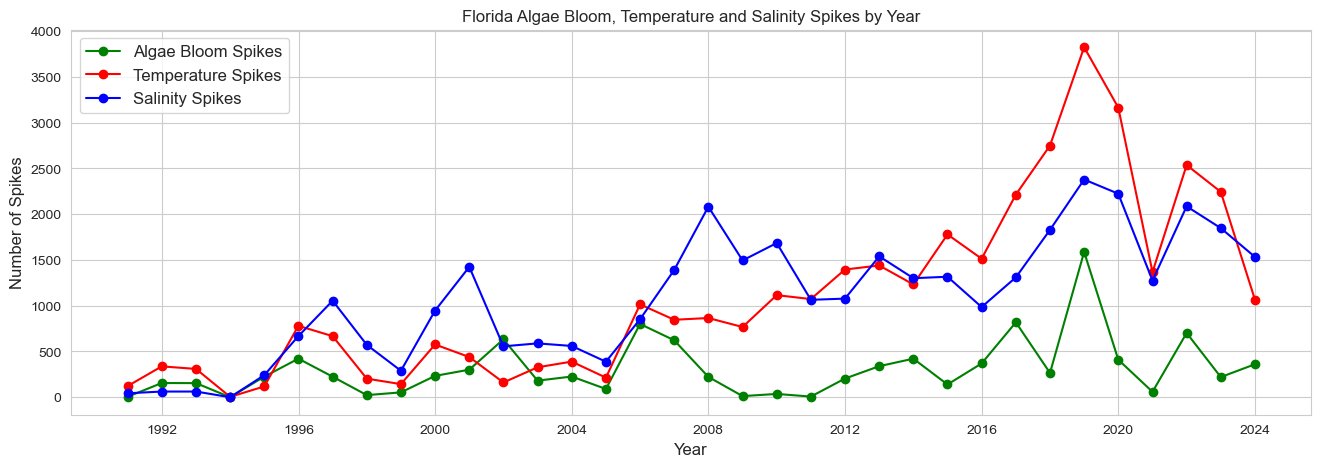

In [6]:
plt.figure(figsize=(16,5))
plt.plot(fl_spikes.year, fl_spikes.spikes,'g-o',label = 'Algae Bloom Spikes')
plt.plot(fl_spikes.year, fl_spikes.spikes_temp,'r-o',label = 'Temperature Spikes' )
plt.plot(fl_spikes.year, fl_spikes.spikes_sal,'b-o', label = 'Salinity Spikes')
plt.title('Florida Algae Bloom, Temperature and Salinity Spikes by Year')
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Spikes", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In order to analyse the `correlation ` between the variables deeper we plot the correlation graphs. Although we will mostly work univariate time series models we will also going to employ `Random Forest Regressor` in which we can use either of the 
`WATER_TEMP` or `SALINITY` as features.

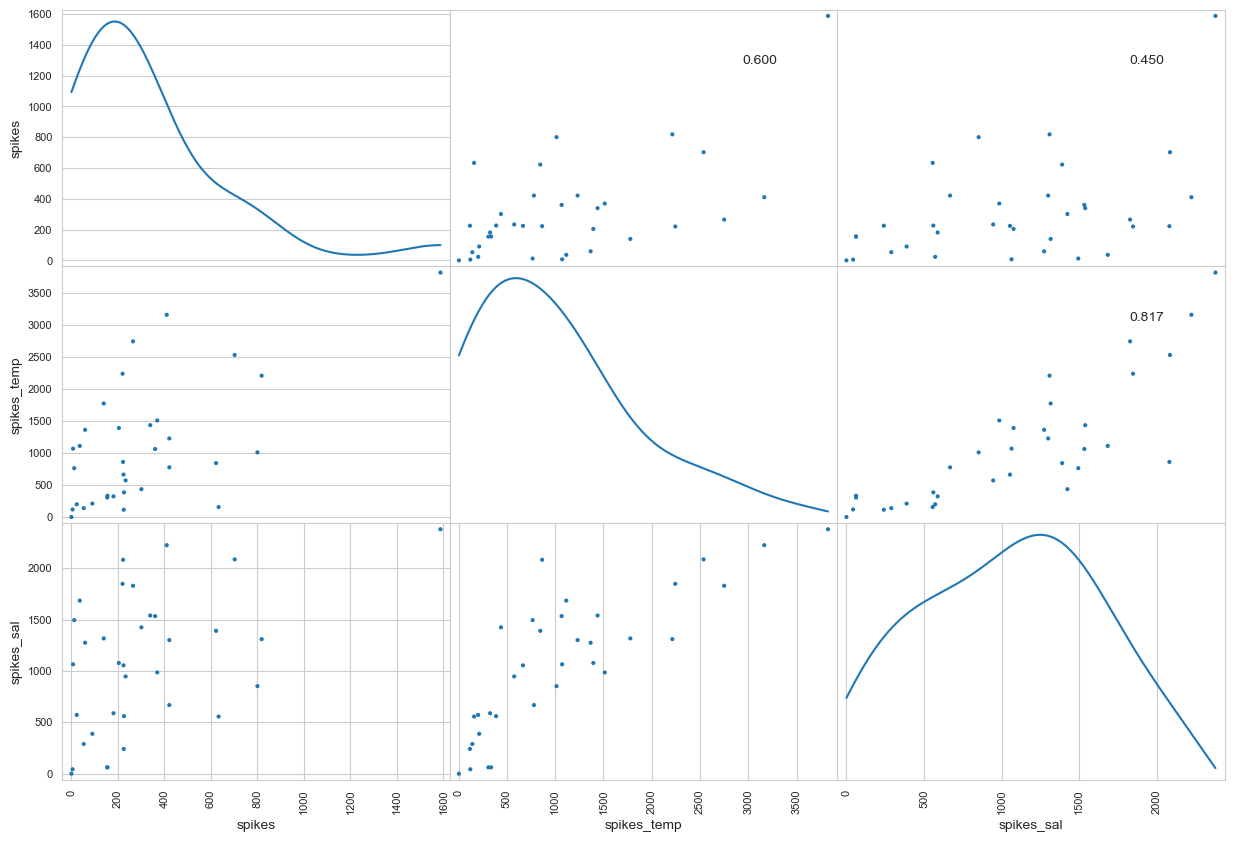

In [7]:
axes = scatter_matrix(fl_spikes[['spikes','spikes_temp','spikes_sal']], alpha=1,figsize=(15, 10), diagonal='kde')
corr = fl_spikes[['spikes','spikes_temp','spikes_sal']].corr().to_numpy()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

Lets make a training and test split. We will leave `2020-2023` data as test and the rest as training.

In [8]:
alg_train =  fl_spikes.loc[fl_spikes.year.dt.year < 2020].copy()
alg_test = fl_spikes.drop(alg_train.index).copy()
forecast_y = 4 #forecasting n years into the future

From previous considerations we assumed we have a non-seasonal data with trend so we have the following baseline models:
- The average baseline forecast,
- The naive baseline forecast,
- Trend baseline forecast,
- Random Walk with Drift baseline forecast,

Below we will compute these baselines.

# Baselines

Below we will first plot the baselines and try to have an idea how they perform. Then for a more solid result we will introduce `cross validation ` (cv) sets and compute the `root mean square error ` (rmse).

### The average forecast

This one basically take the average of all training data and forecast it indefinitely into the future.

In [9]:
train_avg = alg_train.spikes.mean()

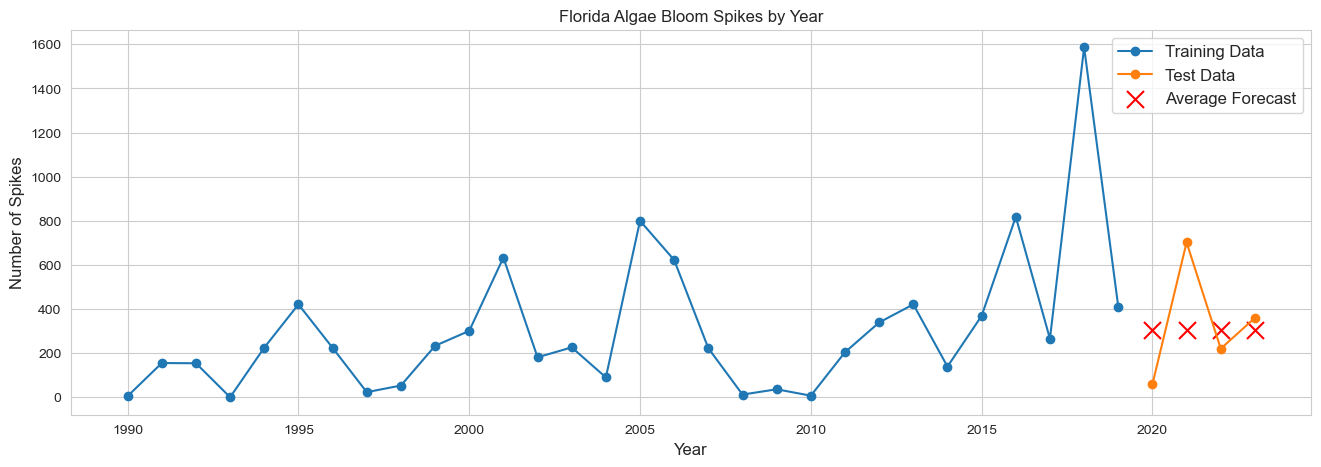

In [10]:
plt.figure(figsize=(16,5))

plt.plot(alg_train.year.dt.year,
            alg_train.spikes,
            '-o',
            label = "Training Data")

plt.plot(alg_test.year.dt.year,
            alg_test.spikes,
            'o-',
            label="Test Data")

plt.scatter(np.arange(start =alg_train.year.dt.year.max()+1, 
         stop = alg_train.year.dt.year.max()+ len(alg_test)+1),
            train_avg*np.ones(len(alg_test)),
            marker='x',
            s=150,
            color='red',
            label="Average Forecast")

plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Florida Algae Bloom Spikes by Year')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Spikes", fontsize=12)

    
plt.show()

### Naive Forecast

This forecast just takes the last training data and predicts it indefinitely.

In [11]:
naive = alg_train.spikes.values[-1]

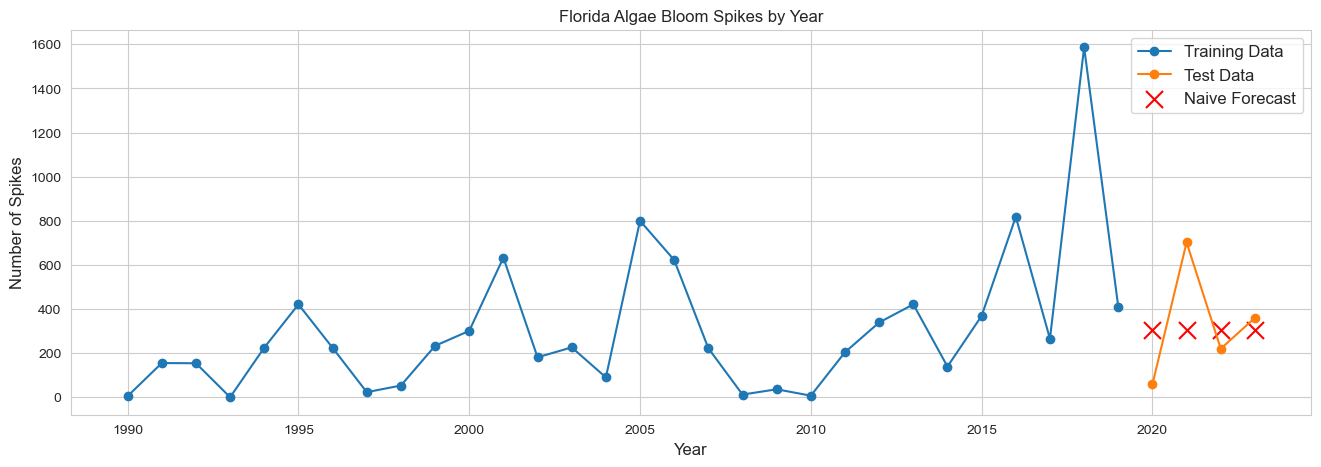

In [12]:
plt.figure(figsize=(16,5))

plt.plot(alg_train.year.dt.year,
            alg_train.spikes,
            '-o',
            label = "Training Data")

plt.plot(alg_test.year.dt.year,
            alg_test.spikes,
            'o-',
            label="Test Data")

plt.scatter(np.arange(start =alg_train.year.dt.year.max()+1, 
         stop = alg_train.year.dt.year.max()+ len(alg_test)+1),
            train_avg*np.ones(len(alg_test)),
            marker='x',
            s=150,
            color='red',
            label="Naive Forecast")

plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Florida Algae Bloom Spikes by Year')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Spikes", fontsize=12)

    
plt.show()

### Trend Forecast

In this case our forecast simply predicts $y_t = \beta_0 + \beta_1 t$ for $t>n$.

In [13]:
## import linear regression
from sklearn.linear_model import LinearRegression

In [14]:
## Make the model object
reg = LinearRegression()

## Fit the model
reg.fit(alg_train.year.dt.year.values.reshape(-1,1),
        alg_train.spikes)

## Make the forecast
trend_pred = reg.predict(alg_test.year.dt.year.values.reshape(-1,1))

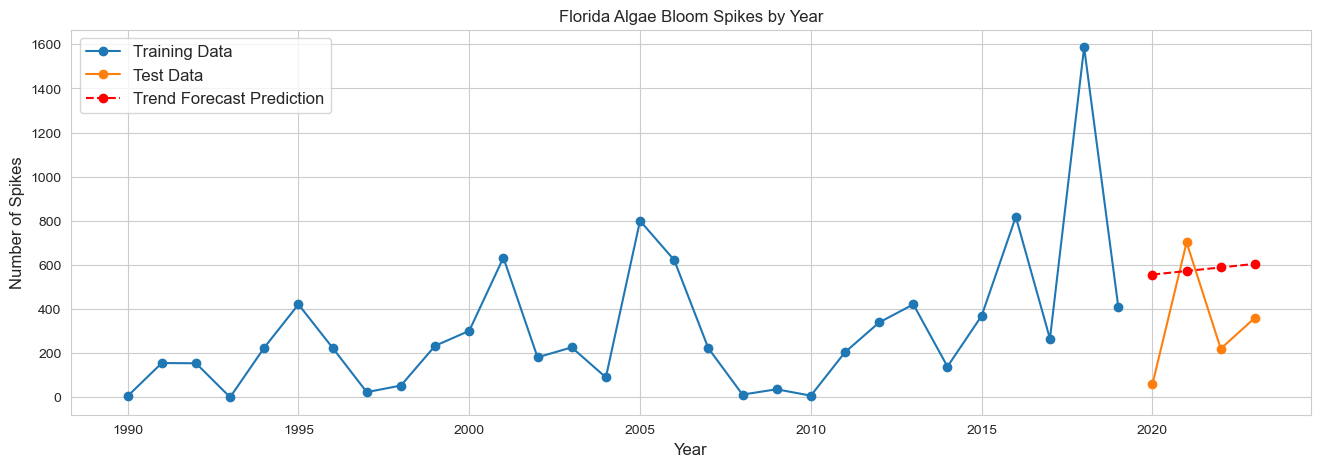

In [15]:
## Plotting the naive prediction 
plt.figure(figsize=(16,5))

plt.plot(alg_train.year.dt.year,
            alg_train.spikes,
            '-o',
            label = "Training Data")

plt.plot(alg_test.year.dt.year,
            alg_test.spikes,
            '-o',
            label="Test Data")

plt.plot(alg_test.year.dt.year,
            trend_pred,
            'r--o',
            label="Trend Forecast Prediction")
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Florida Algae Bloom Spikes by Year')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Spikes", fontsize=12)


plt.show()

### Random walk with drift

In [16]:
beta_hat = alg_train.spikes.diff()[1:].mean() #beta parameter of random walk

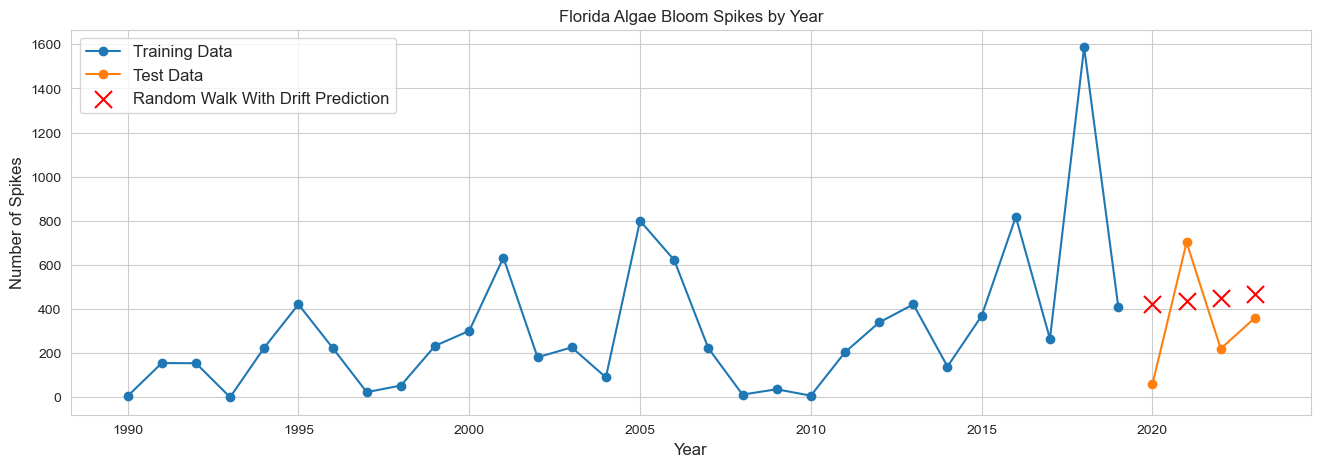

In [17]:
plt.figure(figsize=(16,5))

plt.plot(alg_train.year.dt.year,
            alg_train.spikes,
            '-o',
            label = "Training Data")

plt.plot(alg_test.year.dt.year,
            alg_test.spikes,
            '-o',
            label="Test Data")


plt.scatter(np.arange(start =alg_train.year.dt.year.max()+1, 
         stop = alg_train.year.dt.year.max()+ len(alg_test)+1),
            alg_train.spikes.values[-1] + beta_hat*np.array([1,2,3,4]),
            marker='x',
            s=150,
            color='red',
            label="Random Walk With Drift Prediction")

plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Florida Algae Bloom Spikes by Year')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Spikes", fontsize=12)

    
plt.show()

Now using cross validation let us check which baseline performs better. 

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

Defining split and holdout set sizes.

In [19]:
splits = 5
size = 2
cv = TimeSeriesSplit(splits, 
                     test_size=size)

In [20]:
avg_rmses = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.loc[train_index] #training set
    alg_ho = alg_train.loc[test_index] #holdout set
    
    tt_avg = alg_tt.spikes.mean()
    
    avg_rmses[i] = np.sqrt(mean_squared_error(alg_ho.spikes.values,
                                    tt_avg*np.ones(size)))
    
    i = i + 1
av_base = np.mean(avg_rmses)

In [21]:
naive_rmses = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.loc[train_index] #train set
    alg_ho = alg_train.loc[test_index] #holdout set
    
    tt_naive = alg_tt.spikes.values[-1]
    
    naive_rmses[i] = np.sqrt(mean_squared_error(alg_ho.spikes.values,
                                    tt_naive*np.ones(size)))
    
    i = i + 1
naive_base = np.mean(naive_rmses)    

In [22]:
trend_rmses = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.loc[train_index] #train set
    alg_ho = alg_train.loc[test_index] #holdout set
    
    slr = LinearRegression()
    
    slr.fit(alg_tt.year.dt.year.values.reshape(-1,1),
               alg_tt.spikes.values)
    
    pred_trend = slr.predict(alg_ho.year.dt.year.values.reshape(-1,1))
    trend_rmses[i] = np.sqrt(mean_squared_error(alg_ho.spikes.values,
                                   pred_trend))
    i = i + 1
trend_base = np.mean(trend_rmses)    

In [23]:
walk_rmses = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.loc[train_index]
    alg_ho = alg_train.loc[test_index]
    
    beta_hat = alg_tt.spikes.diff().mean()
    
    pred_walk = alg_tt.spikes.values[-1] + beta_hat*np.array([1,2])
    
    walk_rmses[i] = np.sqrt(mean_squared_error(alg_ho.spikes.values,
                                        pred_walk))
    
    i = i + 1
walk_base = np.mean(walk_rmses)    

Summary of the baselines

In [24]:
pd.DataFrame({'Base Model':['Average Base','Naive Base','Trend Base','Random Walk with Drift']
              , 'RMSE':[av_base,naive_base,trend_base,walk_base]})

,Base Model,RMSE
0,Average Base,360.487543
1,Naive Base,354.065375
2,Trend Base,340.714471
3,Random Walk with Drift,351.795166


# Models

After checking the baselines we will try to compare the `Rolling Average`, `Double Exponential Smoothing`, `ARIMA`, `Random Forest` with respect to the baselines we worked on and try to see if they perform better and which `hyperparameters` to choose to make them perform better.


### Rolling Average

The first model we fit is a rolling average model. Below we tune the moving average window size, $q$, to find the value that minimizes the rmse.

In [25]:
cv = TimeSeriesSplit(splits, test_size=size)

start = 2
end = 25
ra_mse = np.zeros((splits, len(range(start, end))))


i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = alg_tt.spikes[-q:].mean() * np.ones(len(alg_ho))
        
        ra_mse[i,j] = np.sqrt(mean_squared_error( alg_ho.spikes.values, pred))
        j = j + 1
    i = i + 1

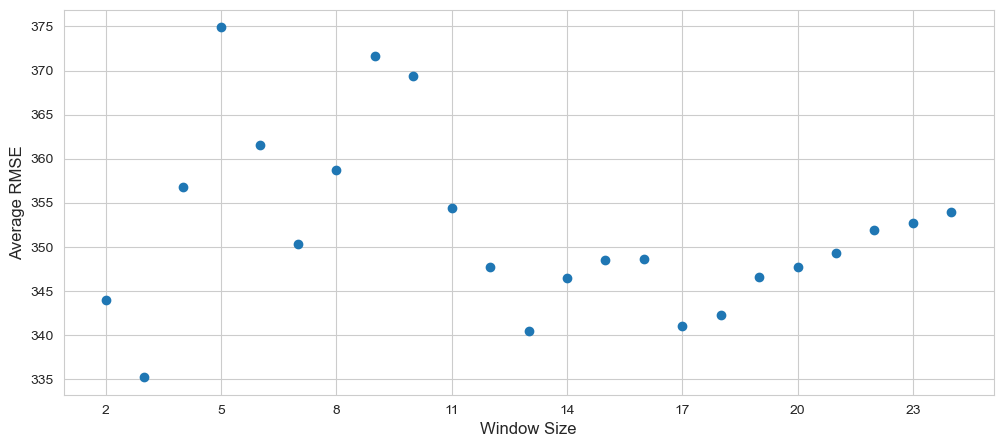

In [26]:
plt.figure(figsize=(12,5))

plt.scatter(range(start,end), np.mean(ra_mse, axis=0))

plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Average RMSE", fontsize=12)

plt.xticks(range(start, end, 3), fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [27]:
print("The window size that minimized the avg. cv RMSE",
      "was q =", 
      range(start,end)[np.argmin(np.mean(ra_mse, axis=0))],
      "\b.",
      "It had a mean cv RMSE of", 
      np.round(np.min(np.mean(ra_mse, axis=0)), 5))
rol_mod = np.round(np.min(np.mean(ra_mse, axis=0)), 5)

The window size that minimized the avg. cv RMSE was q = 3. It had a mean cv RMSE of 335.19483


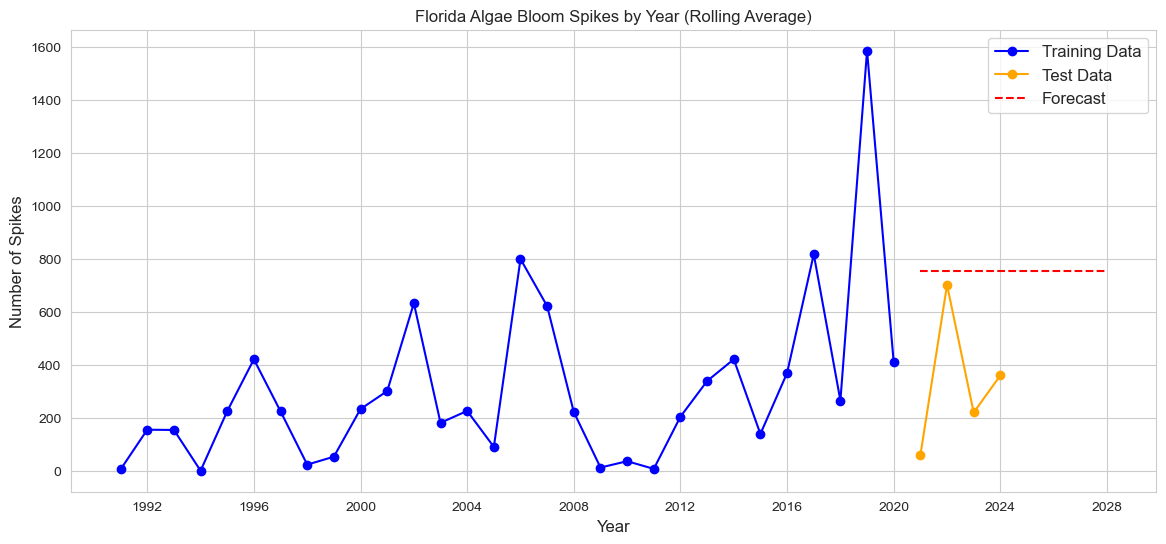

In [28]:
plt.figure(figsize=(14,6))

plt.plot(alg_train.year,
            alg_train.spikes,
            'b-o',
            label='Training Data')


plt.plot(alg_test.year,
            alg_test.spikes,
            color = 'orange',
            marker = 'o',
            label='Test Data')


plt.plot(pd.date_range(alg_test.year.min(),
                    alg_test.year.max() + pd.offsets.DateOffset(years=forecast_y),freq = 'Y').to_series(
                        index=np.arange(alg_test.year.index.min(),alg_test.year.index.max()+forecast_y+1)),
               alg_train.spikes[-3:].mean() * np.ones(len(np.arange(alg_test.year.index.min(),alg_test.year.index.max()+forecast_y+1))),
               '--r',
               label="Forecast")


plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Florida Algae Bloom Spikes by Year (Rolling Average)' )
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Spikes", fontsize=12)

plt.show()

### Exponential Smoothing (Double)

For double exponential smoothing we will do similar hyperparameter search and scan through $\alpha=0$ to $\alpha=0.6$ and $\beta =0$ to $\beta = 0.6$ try to find the value that minimizes RMSE.

In [29]:
## Importing the model from statsmodels
from statsmodels.tsa.holtwinters import Holt

In [30]:
exp_mase = np.zeros((splits, len(np.arange(0, 0.6, .01)), len(np.arange(0, 0.6, .01))))

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for alpha in np.arange(0, 0.6, .01):
        k = 0
        for beta in np.arange(0, 0.6, .01):
            exp_smooth = Holt(alg_tt.spikes.values).fit(smoothing_level=alpha, 
                                                                      smoothing_trend=beta,
                                                                      optimized=False)

            exp_mase[i,j,k] = np.sqrt(mean_squared_error(alg_ho.spikes.values, exp_smooth.forecast(len(alg_ho))))
            k = k + 1
        j = j + 1
    i = i + 1

In [31]:
## This gives us the indices of the smallest
## avg cv rmse
exp_ind = np.unravel_index(np.argmin(np.mean(exp_mase, axis=0), axis=None), 
                           np.mean(exp_mase, axis=0).shape)
np.unravel_index(np.argmin(np.mean(exp_mase, axis=0), axis=None), 
                 np.mean(exp_mase, axis=0).shape)

(59, 4)

In [32]:
print("The alpha and beta values that give a double exponential",
         "smoothing model with lowest avg cv rmse are",
         "alpha = ", np.arange(0, 0.6, .01)[exp_ind[0]],
         "and beta = ", np.arange(0, 0.6, .01)[exp_ind[1]])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_mase, axis=0)[exp_ind],3))
exp_mod = np.round(np.mean(exp_mase, axis=0)[exp_ind],3)
exp_smooth = Holt(alg_train.spikes.values).fit(smoothing_level=np.arange(0, 0.6, .01)[exp_ind[0]], 
                                                                      smoothing_trend=np.arange(0, 0.6, .01)[exp_ind[1]],
                                                                      optimized=False)

The alpha and beta values that give a double exponential smoothing model with lowest avg cv rmse are alpha =  0.59 and beta =  0.04
This model had an avg cv rmse of 320.443


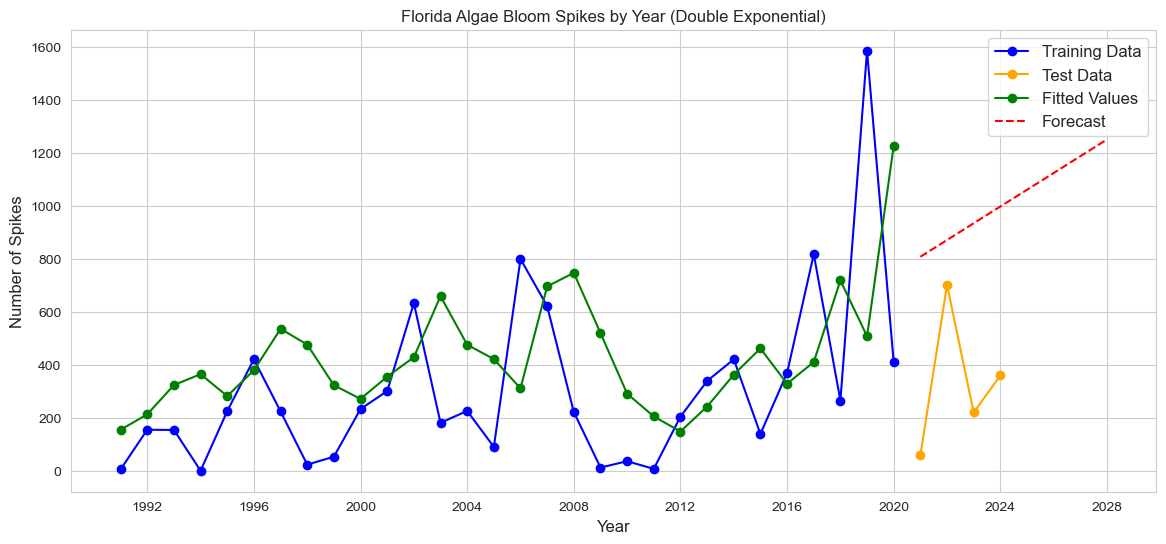

In [33]:
plt.figure(figsize=(14,6))

plt.plot(alg_train.year,
            alg_train.spikes,
            'b-o',
            label='Training Data')


plt.plot(alg_test.year,
            alg_test.spikes,
            color = 'orange',
            marker = 'o',
            label='Test Data')

plt.plot(alg_train.year,
            exp_smooth.fittedvalues,
            'g-o',
            label='Fitted Values')

plt.plot(pd.date_range(alg_test.year.min(),
                   alg_test.year.max() + pd.offsets.DateOffset(years=forecast_y),freq = 'Y').to_series(
                        index=np.arange(alg_test.year.index.min(),alg_test.year.index.max()+forecast_y+1)),
               exp_smooth.forecast(len(np.arange(alg_test.year.index.min(),alg_test.year.index.max()+forecast_y+1))),
               '--r',
               label="Forecast")


plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Florida Algae Bloom Spikes by Year (Double Exponential)')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Spikes", fontsize=12)
plt.show()

### ARIMA

For the ARIMA models we first need to check the Autocorrelation and see if time series we work on is `stationary`. Below we checked the Autocorrelation for first for the usual data then first differenced data. This will help us to determine the $d$ value for ARIMA model.

In [34]:
import statsmodels.api as sm

For the `arima` we will set $d=1$ we then try to find the other parameters $p, q$ two different methods. First one is simply going over a range of parameters and trying to minimise rmse. 

As an alternative to cross validation rmse, another common way to select ARIMA parameters is by minimizing the [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) on the training set.  There is a handy object called `auto_arima` from `pmdarima` which can do automatic order selection in this way.

In [35]:
from statsmodels.tsa.api import ARIMA
from pmdarima import auto_arima

Searching for $p,q$ by `MASE`

In [36]:
import warnings
warnings.filterwarnings('ignore') #added this line not to have warnings for cleaner look
arima_rmse = np.zeros((splits, 4, 4))

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for p in range(4):
        k = 0
        for q in range(4):
            arima = ARIMA(alg_tt.spikes.values,
                               order=(p, 1, q)).fit()
            
            arima_rmse[i,j,k] = np.sqrt(mean_squared_error(alg_ho.spikes.values,  arima.forecast(len(alg_ho))))
            k = k +1
        j = j + 1
    i = i +1

In [37]:
arima_ind = np.unravel_index(np.argmin(np.mean(arima_rmse, axis=0), axis=None), 
                             np.mean(arima_rmse, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_rmse, axis=0), axis=None), 
                 np.mean(arima_rmse, axis=0).shape)

(1, 0)

In [38]:
print("The parameters that give an ARIMA model",
         "with lowest avg cv rmse are",
         "(p,d,q) = ( %s, %s, %s )" %(range(4)[arima_ind[0]], 1, range(4)[arima_ind[1]]))

print("This model had an avg cv rmse of",
         np.round(np.mean(arima_rmse, axis=0)[arima_ind],3))
arima_mod = np.round(np.mean(arima_rmse, axis=0)[arima_ind],3)
arima= ARIMA(alg_train.spikes.values,
                    order = (1,1,1)).fit()

The parameters that give an ARIMA model with lowest avg cv rmse are (p,d,q) = ( 1, 1, 0 )
This model had an avg cv rmse of 343.995


ACF plots for the ARIMA(1,1,1)

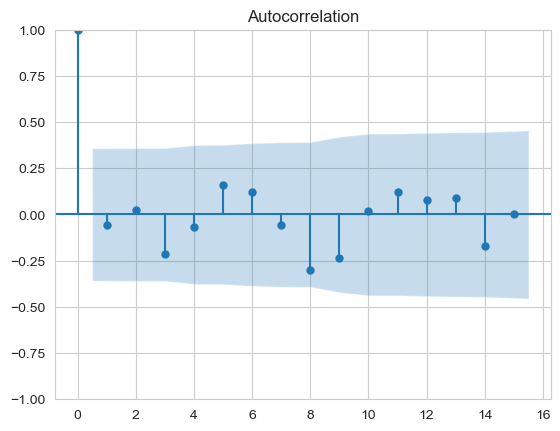

In [39]:
plot_acf(alg_train.spikes.values - arima.fittedvalues)
plt.show()

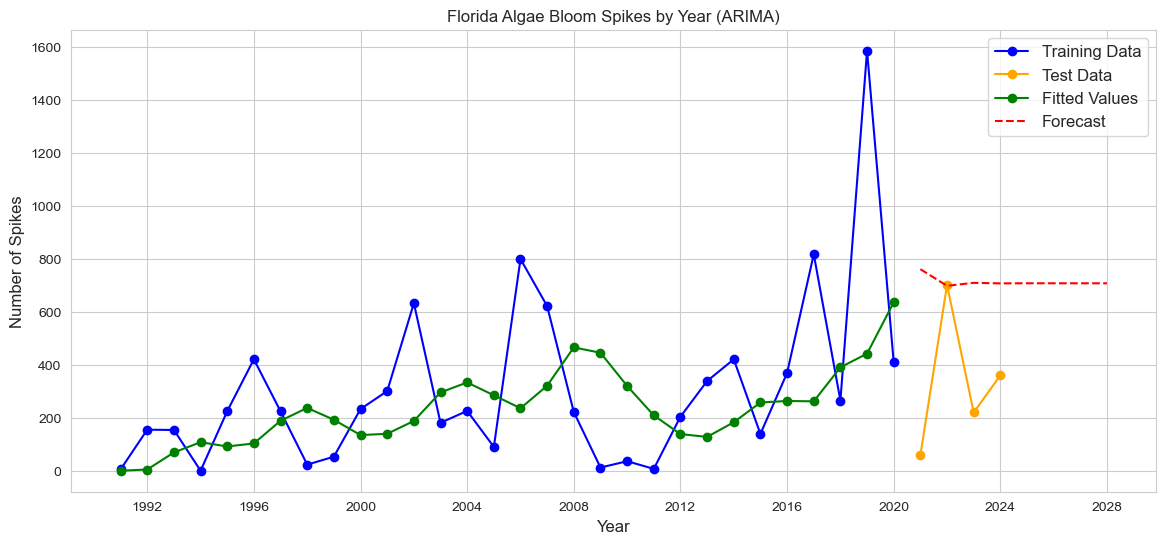

In [40]:
plt.figure(figsize=(14,6))

plt.plot(alg_train.year,
            alg_train.spikes,
            'b-o',
            label='Training Data')


plt.plot(alg_test.year,
            alg_test.spikes,
            color = 'orange',
            marker = 'o',
            label='Test Data')

plt.plot(alg_train.year,
            arima.fittedvalues,
            'g-o',
            label='Fitted Values')

plt.plot(pd.date_range(alg_test.year.min(),
                   alg_test.year.max() + pd.offsets.DateOffset(years=forecast_y),freq = 'Y').to_series(
                        index=np.arange(alg_test.year.index.min(),alg_test.year.index.max()+forecast_y+1)),
               arima.forecast(len(np.arange(alg_test.year.index.min(),alg_test.year.index.max()+forecast_y+1))),
               '--r',
               label="Forecast")


plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Florida Algae Bloom Spikes by Year (ARIMA)')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Spikes", fontsize=12)

plt.show()

Searching $p,q$ by `AIC`, which turned out to be different than the search above.

In [41]:
auto_arima(alg_train.spikes.values, trace=True,max_p=4, max_q=4)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=440.635, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=436.022, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=437.216, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=437.392, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=453.116, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=439.239, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.162 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [42]:
arima_rmse_auto = np.zeros((splits))

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    arima = ARIMA(alg_tt.spikes.values,
                               order=(0, 1, 1)).fit()
    arima_rmse_auto[i] = np.sqrt(mean_squared_error(alg_ho.spikes.values,  arima.forecast(len(alg_ho))))
    
            
    i = i +1
arima_mod_aic = arima_rmse_auto.mean()   
print("This model had an avg cv rmse of", arima_mod_aic )
arima_aic = ARIMA(alg_train.spikes.values,
                    order = (0,1,1)).fit()

This model had an avg cv rmse of 352.81345774738253


ACF plots for the ARIMA(0,1,1)

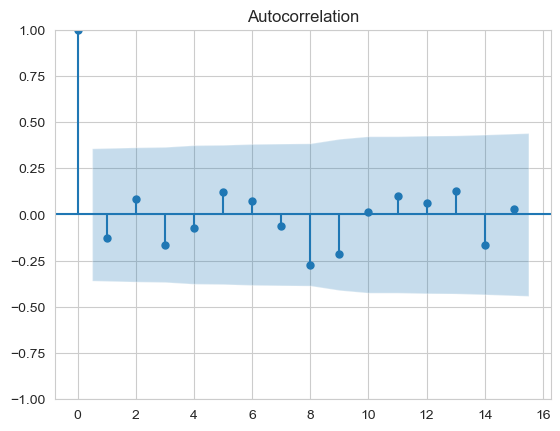

In [43]:
plot_acf(alg_train.spikes.values - arima_aic.fittedvalues)
plt.show()

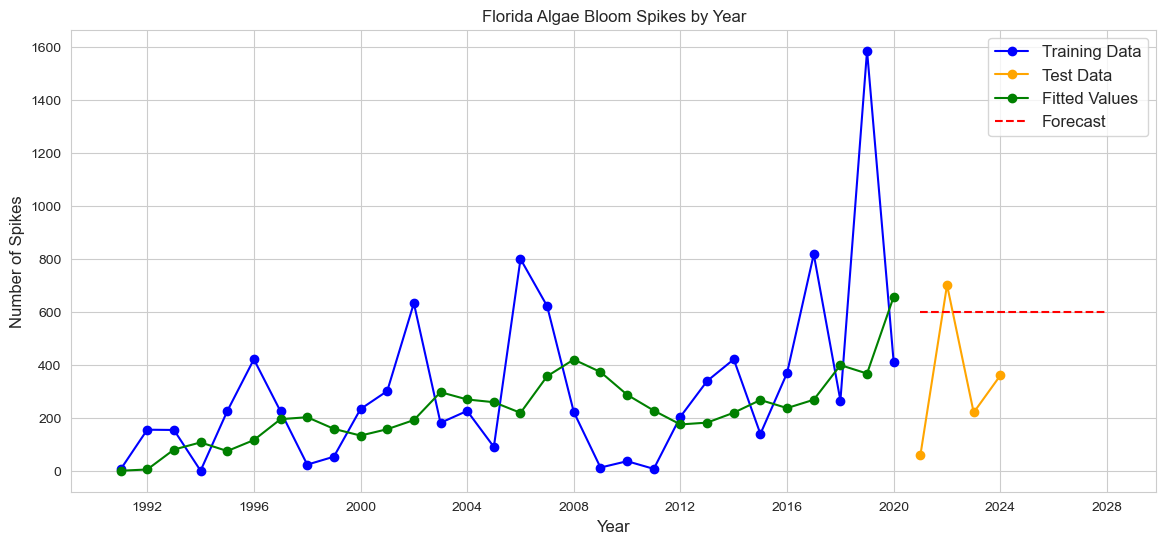

In [44]:
plt.figure(figsize=(14,6))

plt.plot(alg_train.year,
            alg_train.spikes,
            'b-o',
            label='Training Data')


plt.plot(alg_test.year,
            alg_test.spikes,
            color = 'orange',
            marker = 'o',
            label='Test Data')

plt.plot(alg_train.year,
            arima_aic.fittedvalues,
            'g-o',
            label='Fitted Values')

plt.plot(pd.date_range(alg_test.year.min(),
                   alg_test.year.max() + pd.offsets.DateOffset(years=forecast_y),freq = 'Y').to_series(
                        index=np.arange(alg_test.year.index.min(),alg_test.year.index.max()+forecast_y+1)),
               arima_aic.forecast(len(np.arange(alg_test.year.index.min(),alg_test.year.index.max()+forecast_y+1))),
               '--r',
               label="Forecast")


plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Florida Algae Bloom Spikes by Year')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Spikes", fontsize=12)

plt.show()

### Random Forest

Finally we will employ Random Forest to perform a multivariate analysis on our time series. We first use `WATER_TEMP` then `SALINITY` as a feature.

In [45]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score


 Random Forest with `WATER_TEMP`  as a feature.

In [46]:
rf_rmses_auto = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    RF_Model = RandomForestRegressor(max_depth=3, n_estimators=1000,
                                 max_features=1, min_samples_leaf = 1,random_state = 216,oob_score=True)
    rf = RF_Model.fit(alg_tt.spikes_temp.values.reshape(-1, 1), alg_tt.spikes.values)
    rf_rmses_auto[i] = np.sqrt(mean_squared_error(alg_ho.spikes.values,  rf.predict(alg_ho.spikes_temp.values.reshape(-1, 1))))
            
    i = i +1
rforest_temp = np.mean(rf_rmses_auto)
print("The Random Forest model with water temperature had an avg cv rmse of", rforest_temp)    

The Random Forest model with water temperature had an avg cv rmse of 354.9589098835861


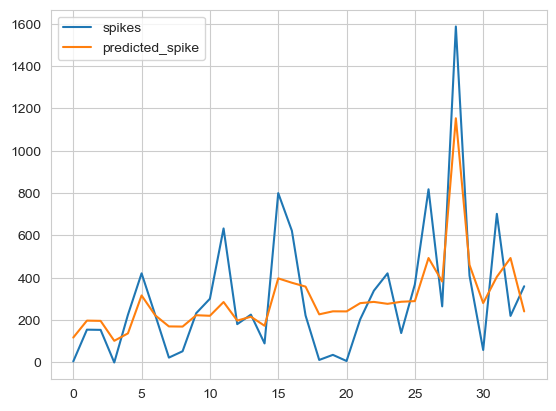

In [47]:
RF_Model = RandomForestRegressor(max_depth=3, n_estimators=1000,
                                 max_features=1,min_samples_leaf = 1,random_state = 216, oob_score=True)
labels = alg_train.spikes 
features = alg_train.spikes_temp
rgr = RF_Model.fit(features.values.reshape(-1, 1), labels.values)
X_test_predict = pd.DataFrame(
    rgr.predict(alg_test.spikes_temp.values.reshape(-1, 1))).rename(
    columns={0:'predicted_spike'}).set_index('predicted_spike')
X_train_predict = pd.DataFrame(
    rgr.predict(alg_train.spikes_temp.values.reshape(-1, 1))).rename(
    columns={0:'predicted_spike'}).set_index('predicted_spike')
RF_predict = X_train_predict._append(X_test_predict)
wtemp = fl_spikes.join((RF_predict.reset_index()))
wtemp[['spikes', 'predicted_spike']].plot()
plt.show()

Random Forest with `SALINITY` as a feature.

In [48]:
rf_rmses_auto = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    RF_Model = RandomForestRegressor(max_depth=3, n_estimators=1000,
                                 max_features=1, min_samples_leaf = 1,random_state = 216, oob_score=True)
    rf = RF_Model.fit(alg_tt.spikes_sal.values.reshape(-1, 1), alg_tt.spikes.values)
    rf_rmses_auto[i] = np.sqrt(mean_squared_error(alg_ho.spikes.values,  rf.predict(alg_ho.spikes_sal.values.reshape(-1, 1))))
            
    i = i +1
rforest_sal = np.mean(rf_rmses_auto) 
print("The Random Forest model with salinity had an avg cv rmse of", rforest_sal)  

The Random Forest model with salinity had an avg cv rmse of 387.7958862325391


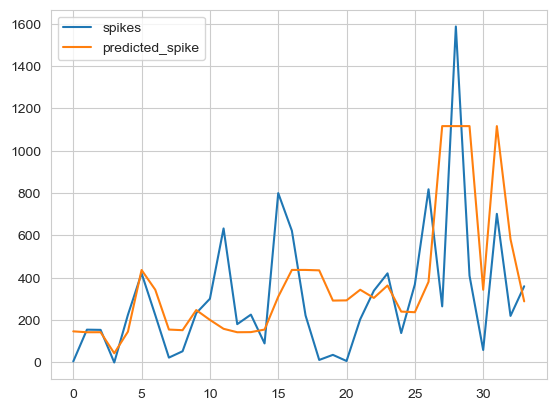

In [49]:
RF_Model = RandomForestRegressor(max_depth=3, n_estimators=1000,
                                 max_features=1, min_samples_leaf = 1,random_state = 216, oob_score=True)
labels = alg_train.spikes 
features = alg_train.spikes_sal
rgr = RF_Model.fit(features.values.reshape(-1, 1), labels.values)
X_test_predict = pd.DataFrame(
    rgr.predict(alg_test.spikes_temp.values.reshape(-1, 1))).rename(
    columns={0:'predicted_spike'}).set_index('predicted_spike')
X_train_predict = pd.DataFrame(
    rgr.predict(alg_train.spikes_temp.values.reshape(-1, 1))).rename(
    columns={0:'predicted_spike'}).set_index('predicted_spike')
RF_predict = X_train_predict._append(X_test_predict)
sal = fl_spikes.join((RF_predict.reset_index()))
sal[['spikes', 'predicted_spike']].plot()
plt.show()

## The Final Results

In [50]:
pd.DataFrame({'Base Model':['Average Base','Naive Base','Trend Base','Random Walk with Drift']
              , 'RMSE':[av_base,naive_base,trend_base,walk_base]}).style.set_caption(
                  'cv RMSE of the Baselines')

,Base Model,RMSE
0,Average Base,360.487543
1,Naive Base,354.065375
2,Trend Base,340.714471
3,Random Walk with Drift,351.795166


In [51]:
pd.DataFrame({'Model':['Rolling Average','Double Exponential Smoothing','ARIMA'
                       ,'ARIMA (AIC)','Random Forest (Temp)','Random Forest (Sal) ']
              , 'cv RMSE':[rol_mod,exp_mod,arima_mod,arima_mod_aic,rforest_temp,rforest_sal]}).style.set_caption(
                  'cv RMSE of the Models')

,Model,cv RMSE
0,Rolling Average,335.194830
1,Double Exponential Smoothing,320.443000
2,ARIMA,343.995000
3,ARIMA (AIC),352.813458
4,Random Forest (Temp),354.958910
5,Random Forest (Sal),387.795886
